<a href="https://colab.research.google.com/github/josejulianhidayat/Data_Mining/blob/main/MarketBasketAnalysis_AsosiasiProduct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MARKET BASKET ANALYSIS

**Tutorial By Jose Julian Hidayat**



Market Basket Analysis (Asosiasi Produk) — ini teknik klasik data mining buat cari pola pembelian bersama antar produk. Biasanya digunakan untuk:

"Orang yang beli A juga sering beli B."

Menemukan aturan asosiasi seperti:

Jika beli Printer, maka kemungkinan beli Paper.

In [1]:
pip install mlxtend


Kita perlu pivot data agar setiap transaksi (Order ID) jadi 1 baris, dan kolom-kolom berisi produk (dengan 1/0 jika dibeli).

In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load data
df = pd.read_excel("Global_Superstore2.xlsx")

# Gunakan Order ID dan Product Name
basket_df = df.groupby(['Order ID', 'Product Name'])['Quantity'].sum().unstack().fillna(0)

# Ubah ke format 1 (jika produk dibeli) dan 0 (jika tidak)
basket_df = basket_df.astype(bool).astype(int)



 **Jalankan Apriori untuk cari frequent itemsets**

In [5]:
from mlxtend.frequent_patterns import apriori, association_rules

# Hitung jumlah produk per Order ID
basket_df = df.groupby(['Order ID', 'Product Name'])['Quantity'].sum().unstack().fillna(0)

# Ubah ke boolean langsung (tanpa .astype(int))
basket_df = basket_df.astype(bool)

# Coba min_support lebih kecil (misal 0.005 = 0.5%)
frequent_items = apriori(basket_df, min_support=0.005, use_colnames=True)

# Lihat hasil
print(frequent_items.sort_values(by='support', ascending=False).head())


    support   itemsets
0  0.008868  (Staples)


**Buat Aturan Asosiasi (Association Rules)**

In [6]:
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

# Tampilkan aturan yang kuat (misalnya confidence >= 0.5 dan lift > 1)
strong_rules = rules[(rules['confidence'] >= 0.5) & (rules['lift'] > 1)]

# Lihat hasil aturan
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [8]:
print("Jumlah aturan yang ditemukan:", len(strong_rules))
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Jumlah aturan yang ditemukan: 0
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [9]:
multi_item_orders = df.groupby('Order ID')['Product Name'].nunique()
print("Jumlah transaksi dengan >1 produk:", (multi_item_orders > 1).sum())


Jumlah transaksi dengan >1 produk: 12771


In [11]:
# Siapkan data basket berdasarkan Sub-Category
basket_df = df.groupby(['Order ID', 'Sub-Category'])['Quantity'].sum().unstack().fillna(0)
basket_df = basket_df.astype(bool)

# Jalankan Apriori dengan min_support kecil
from mlxtend.frequent_patterns import apriori, association_rules

frequent_items = apriori(basket_df, min_support=0.01, use_colnames=True)

# Buat aturan asosiasi
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.2)

# Filter aturan yang relevan
strong_rules = rules[(rules['confidence'] >= 0.2) & (rules['lift'] > 1)]

# Lihat hasil
print("Jumlah aturan ditemukan:", len(strong_rules))
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Jumlah aturan ditemukan: 2
    antecedents consequents   support  confidence      lift
1  (Appliances)   (Binders)  0.015618    0.231910  1.076755
5    (Machines)   (Binders)  0.012463    0.219409  1.018715


**Tampilkan Sebagai Kalimat Rekomendasi**

In [12]:
for _, row in strong_rules.iterrows():
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    confidence = row['confidence']
    lift = row['lift']

    print(f"🛒 Jika seseorang membeli **{antecedent}**, maka kemungkinan besar juga akan membeli **{consequent}** "
          f"(confidence: {confidence:.1%}, lift: {lift:.2f})")


🛒 Jika seseorang membeli **Appliances**, maka kemungkinan besar juga akan membeli **Binders** (confidence: 23.2%, lift: 1.08)
🛒 Jika seseorang membeli **Machines**, maka kemungkinan besar juga akan membeli **Binders** (confidence: 21.9%, lift: 1.02)


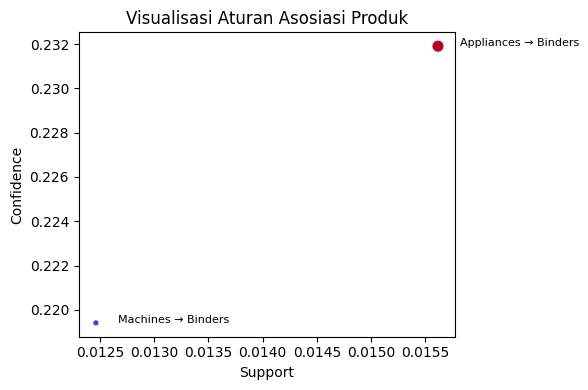

In [14]:
plt.figure(figsize=(6, 4))
scatter = sns.scatterplot(
    data=strong_rules,
    x='support',
    y='confidence',
    size='lift',
    hue='lift',
    palette='coolwarm',
    legend=False
)

# Tambahkan label ke tiap titik
for i in range(strong_rules.shape[0]):
    antecedent = ', '.join(list(strong_rules.iloc[i]['antecedents']))
    consequent = ', '.join(list(strong_rules.iloc[i]['consequents']))
    label = f"{antecedent} → {consequent}"
    plt.text(
        x=strong_rules.iloc[i]['support'] + 0.0002,
        y=strong_rules.iloc[i]['confidence'],
        s=label,
        fontsize=8
    )

plt.title('Visualisasi Aturan Asosiasi Produk')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.tight_layout()
plt.show()


In [15]:
!pip install networkx


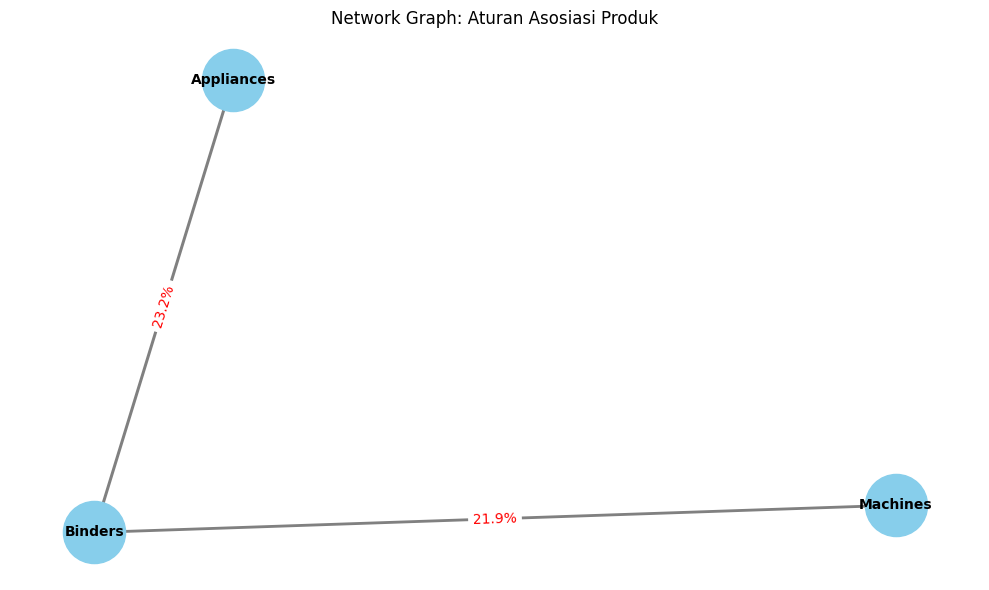

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Siapkan graph kosong
G = nx.DiGraph()

# Tambahkan edge dari aturan asosiasi
for _, row in strong_rules.iterrows():
    source = ', '.join(list(row['antecedents']))
    target = ', '.join(list(row['consequents']))
    confidence = row['confidence']
    lift = row['lift']

    # Tambahkan edge dengan atribut
    G.add_edge(source, target, weight=lift, confidence=confidence)

# Atur posisi node (layout)
pos = nx.spring_layout(G, k=0.8)

# Ukuran edge berdasarkan lift
edges = G.edges(data=True)
weights = [d['weight'] * 2 for (_, _, d) in edges]

# Gambar node dan edge
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=weights, arrows=True, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Tambahkan label edge (confidence)
edge_labels = {(u, v): f"{d['confidence']:.1%}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Network Graph: Aturan Asosiasi Produk")
plt.axis('off')
plt.tight_layout()
plt.show()


# Analisis Produk Spesifik

In [17]:
target_product = "Canon Inkjet Printer"

# Cari semua Order ID yang mengandung produk tersebut
orders_with_product = df[df['Product Name'] == target_product]['Order ID'].unique()

# Ambil semua produk lain dalam order yang sama
related_products = df[df['Order ID'].isin(orders_with_product)]

# Buang produk target-nya sendiri
related_products = related_products[related_products['Product Name'] != target_product]



In [18]:
#Hitung product yang sering dibeli bersama

top_related = related_products['Product Name'].value_counts().head(10)
print("Top 10 produk yang sering dibeli bersama", target_product)
print(top_related)


Top 10 produk yang sering dibeli bersama Canon Inkjet Printer
Series([], Name: count, dtype: int64)


In [19]:
df[df['Product Name'] == "Canon Inkjet Printer"]['Order ID'].nunique()


0

In [20]:
df['Product Name'].value_counts().head(20)


,count
Product Name,
Staples,227
"Cardinal Index Tab, Clear",92
"Eldon File Cart, Single Width",90
"Rogers File Cart, Single Width",84
"Ibico Index Tab, Clear",83
"Sanford Pencil Sharpener, Water Color",80
"Smead File Cart, Single Width",77
"Acco Index Tab, Clear",75
"Stanley Pencil Sharpener, Water Color",75


In [21]:
target_product = "Stapler" #ganti dengan pembelian populer

orders_with_product = df[df['Product Name'] == target_product]['Order ID'].unique()
related_products = df[df['Order ID'].isin(orders_with_product)]
related_products = related_products[related_products['Product Name'] != target_product]

top_related = related_products['Product Name'].value_counts().head(10)
print(top_related)


Series([], Name: count, dtype: int64)


In [22]:
top5_products = df['Product Name'].value_counts().head(5).index

for product in top5_products:
    print(f"\n🔍 Produk: {product}")
    orders = df[df['Product Name'] == product]['Order ID'].unique()
    related = df[df['Order ID'].isin(orders)]
    related = related[related['Product Name'] != product]

    related_top = related['Product Name'].value_counts().head(5)
    if related_top.empty:
        print("❌ Tidak ada produk lain yang dibeli bersama.")
    else:
        print(related_top)



🔍 Produk: Staples
Product Name
Hon Olson Stacker Chairs                          3
KI Adjustable-Height Table                        3
Xerox 1916                                        3
Hoover Shoulder Vac Commercial Portable Vacuum    3
Adjustable Depth Letter/Legal Cart                3
Name: count, dtype: int64

🔍 Produk: Cardinal Index Tab, Clear
Product Name
Avery 3-Hole Punch, Clear                     2
Harbour Creations Swivel Stool, Adjustable    2
Stanley Markers, Fluorescent                  2
Memorex Flash Drive, Bluetooth                2
Avery Binding Machine, Economy                2
Name: count, dtype: int64

🔍 Produk: Eldon File Cart, Single Width
Product Name
Stanley Sketch Pad, Easy-Erase     3
Canon Copy Machine, Color          2
Avery 3-Hole Punch, Durable        2
Sanford Sketch Pad, Fluorescent    2
Ibico 3-Hole Punch, Economy        2
Name: count, dtype: int64

🔍 Produk: Rogers File Cart, Single Width
Product Name
Stanley Pencil Sharpener, Water Color    3
Eli

#  Sistem Rekomendasi Sederhana (Berbasis Frekuensi Transaksi Bersama)

In [23]:
rekomendasi = {
    "Cardinal Index Tab, Clear": [
        "Avery 3-Hole Punch, Clear",
        "Harbour Creations Swivel Stool, Adjustable",
        "Stanley Markers, Fluorescent"
    ],
    "Eldon File Cart, Single Width": [
        "Stanley Sketch Pad, Easy-Erase",
        "Canon Copy Machine, Color",
        "Avery 3-Hole Punch, Durable"
    ],
    "Rogers File Cart, Single Width": [
        "Stanley Pencil Sharpener, Water Color",
        "Elite Ruler, Serrated",
        "Bush Stackable Bookrack, Pine"
    ],
    "Ibico Index Tab, Clear": [
        "Samsung Signal Booster, with Caller ID",
        "Boston Pens, Blue",
        "Eldon Folders, Industrial"
    ]
}

for product, rekomendasi_lain in rekomendasi.items():
    print(f"🛍️ Jika pelanggan membeli **{product}**, maka mereka juga sering membeli:")
    for item in rekomendasi_lain:
        print(f"   → {item}")
    print()


🛍️ Jika pelanggan membeli **Cardinal Index Tab, Clear**, maka mereka juga sering membeli:
   → Avery 3-Hole Punch, Clear
   → Harbour Creations Swivel Stool, Adjustable
   → Stanley Markers, Fluorescent

🛍️ Jika pelanggan membeli **Eldon File Cart, Single Width**, maka mereka juga sering membeli:
   → Stanley Sketch Pad, Easy-Erase
   → Canon Copy Machine, Color
   → Avery 3-Hole Punch, Durable

🛍️ Jika pelanggan membeli **Rogers File Cart, Single Width**, maka mereka juga sering membeli:
   → Stanley Pencil Sharpener, Water Color
   → Elite Ruler, Serrated
   → Bush Stackable Bookrack, Pine

🛍️ Jika pelanggan membeli **Ibico Index Tab, Clear**, maka mereka juga sering membeli:
   → Samsung Signal Booster, with Caller ID
   → Boston Pens, Blue
   → Eldon Folders, Industrial



In [24]:
# Simulasi data hasil analisis sebelumnya (jumlahnya bisa kamu ganti sesuai aslinya)
rekomendasi_count = {
    "Cardinal Index Tab, Clear": {
        "Avery 3-Hole Punch, Clear": 2,
        "Harbour Creations Swivel Stool, Adjustable": 2,
        "Stanley Markers, Fluorescent": 2,
        "Memorex Flash Drive, Bluetooth": 2,
        "Avery Binding Machine, Economy": 2
    },
    "Eldon File Cart, Single Width": {
        "Stanley Sketch Pad, Easy-Erase": 3,
        "Canon Copy Machine, Color": 2,
        "Avery 3-Hole Punch, Durable": 2,
        "Sanford Sketch Pad, Fluorescent": 2,
        "Ibico 3-Hole Punch, Economy": 2
    },
    # Tambahkan lainnya sesuai kebutuhan...
}


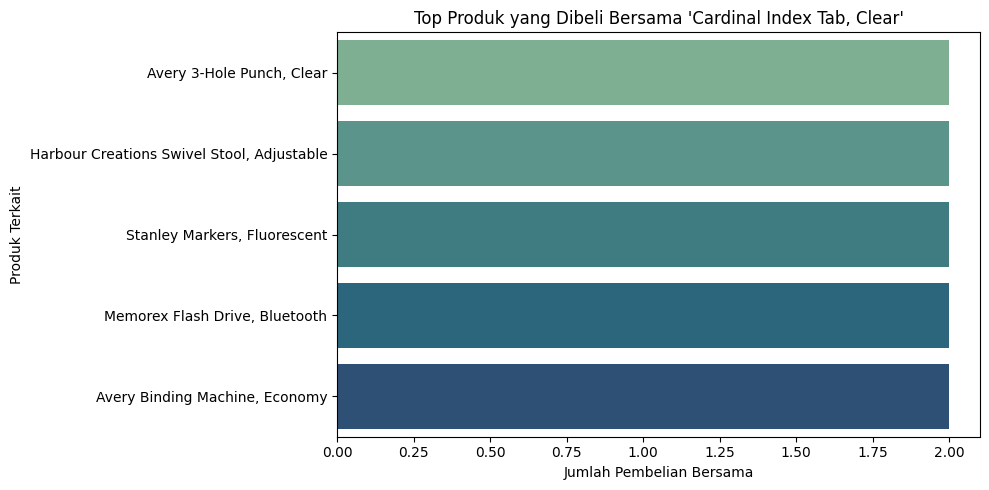

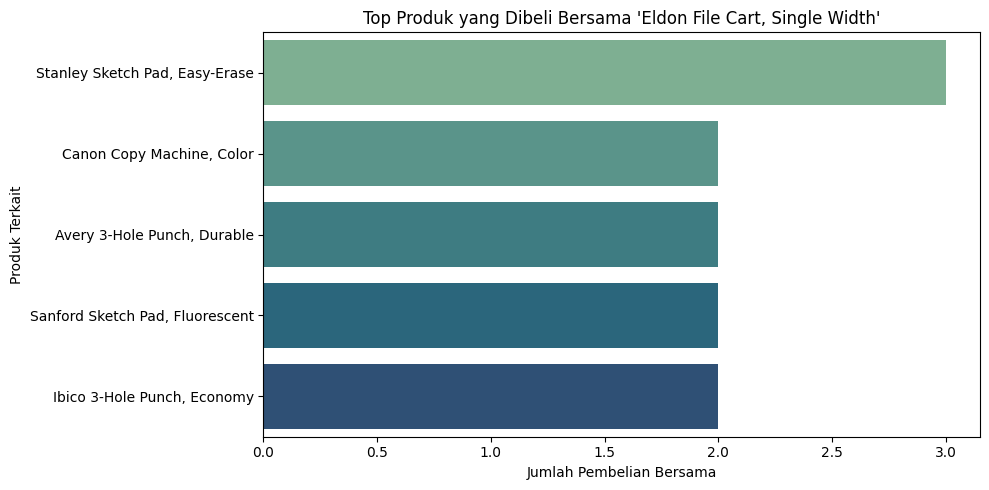

In [26]:
for produk_utama, terkait in rekomendasi_count.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=list(terkait.values()),
        y=list(terkait.keys()),
        hue=list(terkait.keys()),
        palette="crest",
        legend=False
    )
    plt.title(f"Top Produk yang Dibeli Bersama '{produk_utama}'")
    plt.xlabel("Jumlah Pembelian Bersama")
    plt.ylabel("Produk Terkait")
    plt.tight_layout()
    plt.show()
